![lop](../../images/logo_diive1_128px.png)
# **Format EddyPro _fluxnet_ output files for upload to FLUXNET database**

**Notebook creation date**: 1 Jul 2023
**Author**: Lukas Hörtnagl (holukas@ethz.ch)
---
Example notebook for class `FormatEddyProFluxnetFileForUpload` in `diive.pkgs.formats.fluxnet` of the time series processing library `diive`.  

# Background

- Eddypro outputs `_fluxnet_` files
- The files cannot be directly uploaded to the FLUXNET database
- The class `ConvertEddyProFluxnetFileForUpload` helps in formatting the files to comply with FLUXNET requirements for data sharing

## From docstring

Helper class to convert EddyPro _fluxnet_ output files to the file
format required for data upload (data sharing) to FLUXNET

The class does the following:
- Search source folder for _fluxnet_ files
- Load data from all found files and store in dataframe
- Make subset that contains required variables
- Set missing values to FLUXNET format (-9999)
- Rename variables by adding the FLUXNET suffix (_1_1_1)
- Insert two timestamp columns denoting START and END of averaging interval
- Format the two timestamp columns to FLUXNET format YYYYMMDDhhmm
- Save data from dataframe to yearly files

# Imports

In [23]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from diive.pkgs.formats.fluxnet import FormatEddyProFluxnetFileForUpload
from diive.core.plotting.heatmap_datetime import HeatmapDateTime

# Source and output folders

In [2]:
SOURCE = r"L:\Sync\luhk_work\_current\fru\Level-1_results_fluxnet\0-eddypro_fluxnet_files"
OUTDIR = r"L:\Sync\luhk_work\_current\fru\Level-1_results_fluxnet\1-formatted_for_upload"

# Merge files, format data and save yearly files

In [3]:
con = FormatEddyProFluxnetFileForUpload(
    site='CH-FRU',
    sourcedir=SOURCE,
    outdir=OUTDIR,
    limit_n_files=None,
    add_runid=True)
con.run()

Searching for EDDYPRO_FLUXNET_30MIN files with extension .csv andID _fluxnet_ in folder L:\Sync\luhk_work\_current\fru\Level-1_results_fluxnet\0-eddypro_fluxnet_files ...
    Found 18 files:
       --> L:\Sync\luhk_work\_current\fru\Level-1_results_fluxnet\0-eddypro_fluxnet_files\2005_eddypro_CH-FRU_FR-20230430-150230_fluxnet_2023-04-30T205349_adv.csv
       --> L:\Sync\luhk_work\_current\fru\Level-1_results_fluxnet\0-eddypro_fluxnet_files\2006_eddypro_CH-FRU_FR-20230429-014233_fluxnet_2023-04-29T152920_adv.csv
       --> L:\Sync\luhk_work\_current\fru\Level-1_results_fluxnet\0-eddypro_fluxnet_files\2007_eddypro_CH-FRU_FR-20230429-013855_fluxnet_2023-04-29T140625_adv.csv
       --> L:\Sync\luhk_work\_current\fru\Level-1_results_fluxnet\0-eddypro_fluxnet_files\2008_eddypro_CH-FRU_FR-20230429-013552_fluxnet_2023-04-29T154708_adv.csv
       --> L:\Sync\luhk_work\_current\fru\Level-1_results_fluxnet\0-eddypro_fluxnet_files\2009_eddypro_CH-FRU_FR-20230428-010024_fluxnet_2023-04-28T143645_ad

# Results

- The merged file data from all files can be directly returned with `.get_data()`
- Note that the dataframe below does not show exactly how the data look like in the formatted data files, but how data were stored in `diive`, hence the timestamp index `TIMESTAMP_MIDDLE`
- The yearly files do not contain the timestamp index `TIMESTAMP_MIDDLE`

In [4]:
data_fluxnet = con.get_data()
data_fluxnet

,TIMESTAMP_START,TIMESTAMP_END,FC_1_1_1,FC_SSITC_TEST_1_1_1,SC_SINGLE_1_1_1,CO2_1_1_1,LE_1_1_1,LE_SSITC_TEST_1_1_1,SLE_SINGLE_1_1_1,H2O_1_1_1,H_1_1_1,H_SSITC_TEST_1_1_1,SH_SINGLE_1_1_1,USTAR_1_1_1,WD_1_1_1,WS_1_1_1,FETCH_70_1_1_1,FETCH_90_1_1_1,FETCH_MAX_1_1_1,SW_IN_1_1_1,TA_1_1_1,RH_1_1_1,PA_1_1_1,LW_IN_1_1_1,PPFD_IN_1_1_1
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,,,,,
2005-07-05 08:45:00,200507050830,200507050900,-1.452050,1.0,-9999.000000,409.921,0.319460,1.0,-9999.000000,12.54120,1.016460,1.0,-9999.000000,0.004104,113.1020,0.015840,-9999.0,-9999.0,-9999.0,-9999.0,-9999.00000,-9999.0000,-9999.0,-9999.000,-9999.0
2005-07-05 09:15:00,200507050900,200507050930,0.207326,2.0,0.761637,424.090,0.067138,2.0,-0.632032,12.27330,0.183814,1.0,-1.257310,0.006308,125.1690,0.018193,-9999.0,-9999.0,-9999.0,-9999.0,-9999.00000,-9999.0000,-9999.0,-9999.000,-9999.0
2005-07-05 09:45:00,200507050930,200507051000,-0.381113,2.0,-1.901180,388.776,-0.108901,2.0,-0.699526,11.97740,1.324690,1.0,-0.668700,0.006090,131.1880,0.015611,-9999.0,-9999.0,-9999.0,-9999.0,-9999.00000,-9999.0000,-9999.0,-9999.000,-9999.0
2005-07-05 10:15:00,200507051000,200507051030,0.154419,1.0,-0.311197,382.996,-0.064659,1.0,-0.486481,11.77160,0.082388,1.0,-0.000813,0.007233,133.9610,0.017642,-9999.0,-9999.0,-9999.0,-9999.0,-9999.00000,-9999.0000,-9999.0,-9999.000,-9999.0
2005-07-05 10:45:00,200507051030,200507051100,-0.240110,2.0,2.388140,427.468,-0.040537,2.0,-0.185020,11.69310,-0.096005,1.0,1.230580,0.006679,108.8060,0.013876,-9999.0,-9999.0,-9999.0,-9999.0,-9999.00000,-9999.0000,-9999.0,-9999.000,-9999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 22:45:00,202212312230,202212312300,1.210100,0.0,0.069432,421.579,7.121200,1.0,0.108045,8.64158,-25.960300,0.0,-0.674189,0.131824,54.6935,0.660836,-9999.0,-9999.0,-9999.0,0.0,10.40080,62.5504,-9999.0,278.846,0.0
2022-12-31 23:15:00,202212312300,202212312330,-1.503480,2.0,0.029350,422.113,-7.078180,1.0,-0.071440,8.61249,11.805700,2.0,-2.362870,0.178685,88.4788,0.535631,-9999.0,-9999.0,-9999.0,0.0,8.92672,68.8316,-9999.0,271.380,0.0
2022-12-31 23:45:00,202212312330,202301010000,4.104030,0.0,-0.038788,421.408,-0.858139,0.0,0.522764,8.82527,-52.880900,0.0,0.081891,0.095143,108.9400,0.586568,-9999.0,-9999.0,-9999.0,0.0,8.97778,70.3356,-9999.0,277.935,0.0


# Plot some key variables

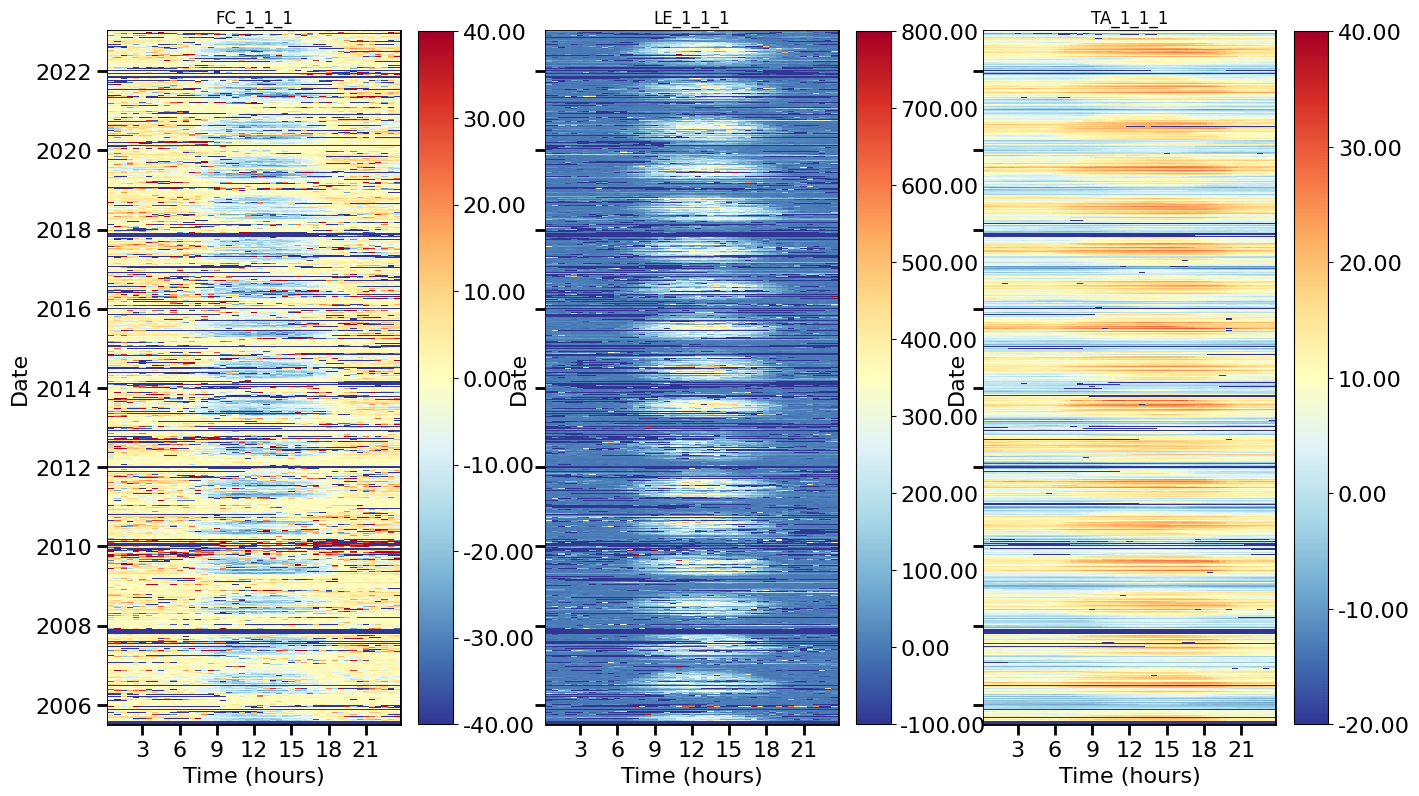

In [8]:
fig = plt.figure(facecolor='white', figsize=(16, 9))
gs = gridspec.GridSpec(1, 3)  # rows, cols
ax_fc = fig.add_subplot(gs[0, 0])
ax_le = fig.add_subplot(gs[0, 1])
ax_ta = fig.add_subplot(gs[0, 2])
HeatmapDateTime(ax=ax_fc, series=data_fluxnet['FC_1_1_1'], vmin=-40, vmax=40).plot()
HeatmapDateTime(ax=ax_le, series=data_fluxnet['LE_1_1_1'], vmin=-100, vmax=800).plot()
HeatmapDateTime(ax=ax_ta, series=data_fluxnet['TA_1_1_1'], vmin=-20, vmax=40).plot()
ax_fc.set_title("FC_1_1_1", color='black')
ax_le.set_title("LE_1_1_1", color='black')
ax_ta.set_title("TA_1_1_1", color='black')
ax_le.tick_params(left=True, right=False, top=False, bottom=True,
                     labelleft=False, labelright=False, labeltop=False, labelbottom=True)
ax_ta.tick_params(left=True, right=False, top=False, bottom=True,
                     labelleft=False, labelright=False, labeltop=False, labelbottom=True)

# Plot all variables

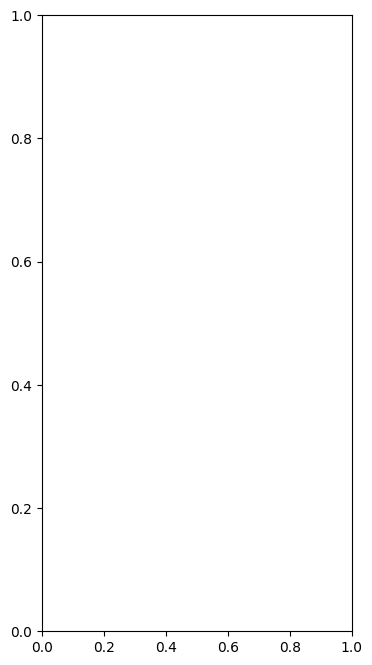

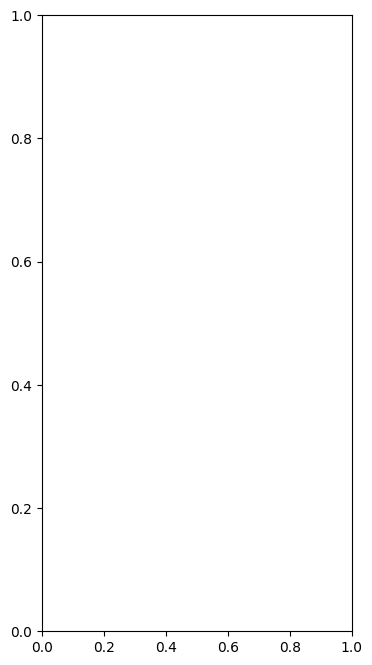

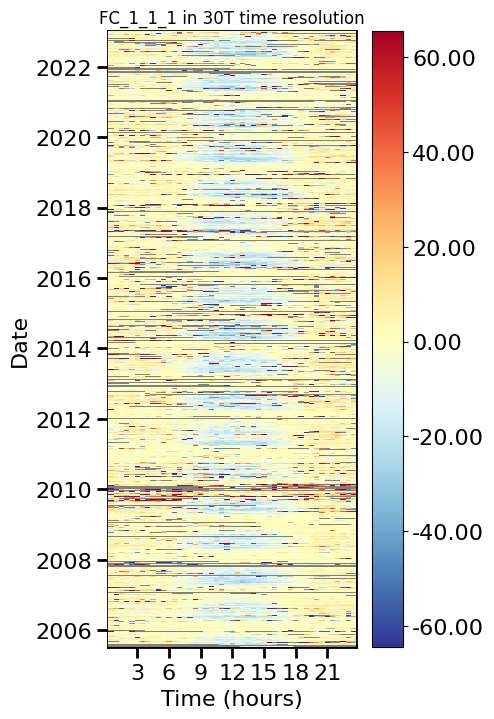

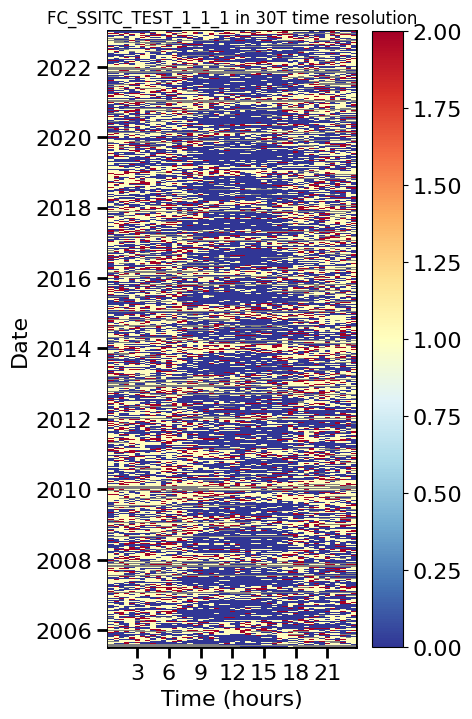

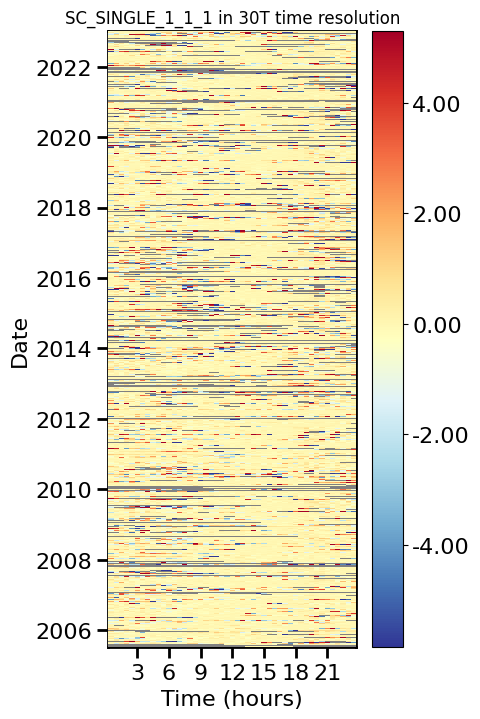

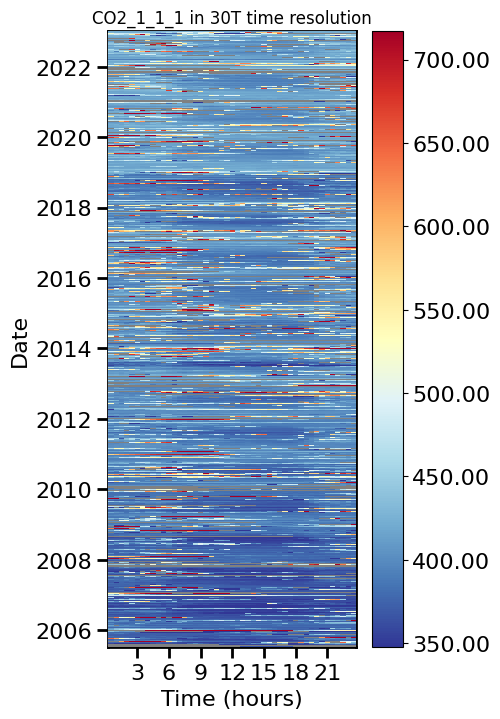

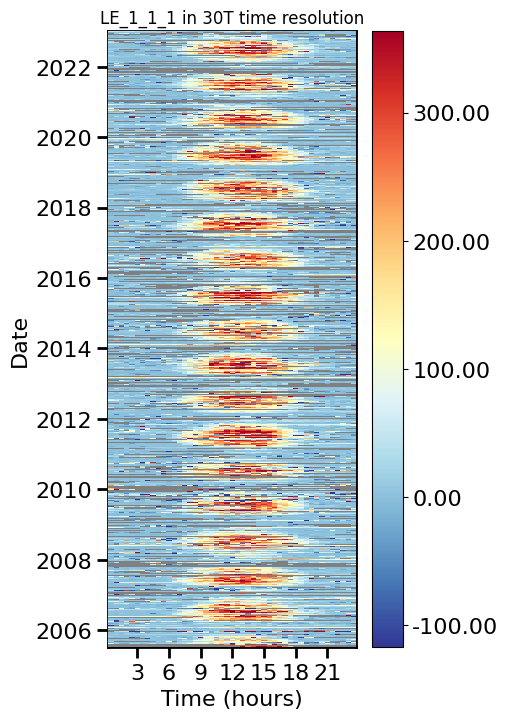

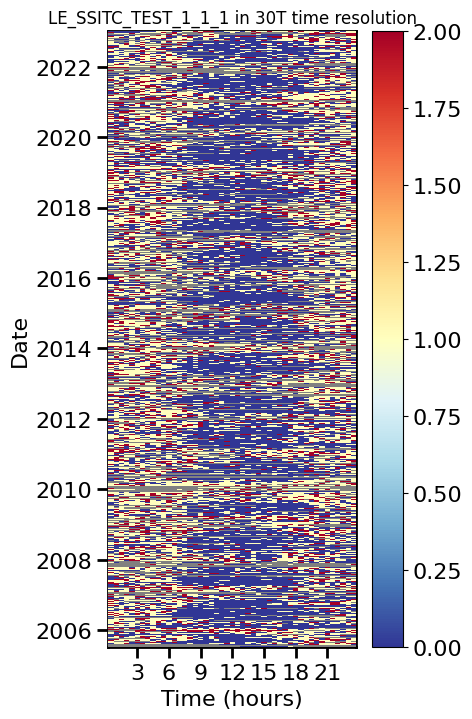

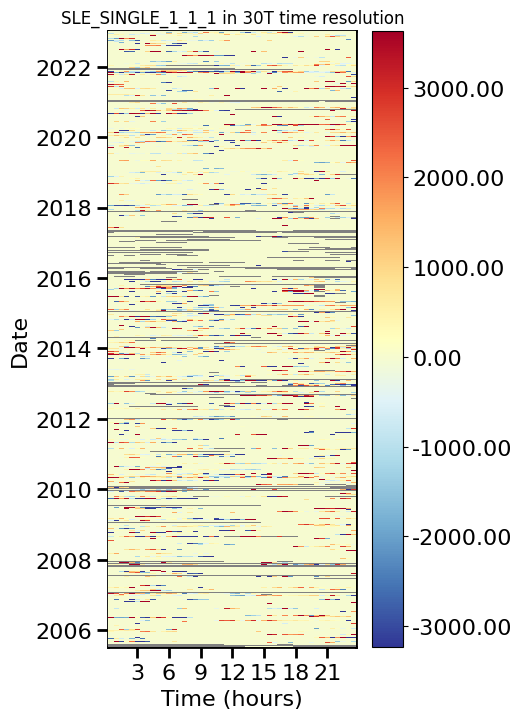

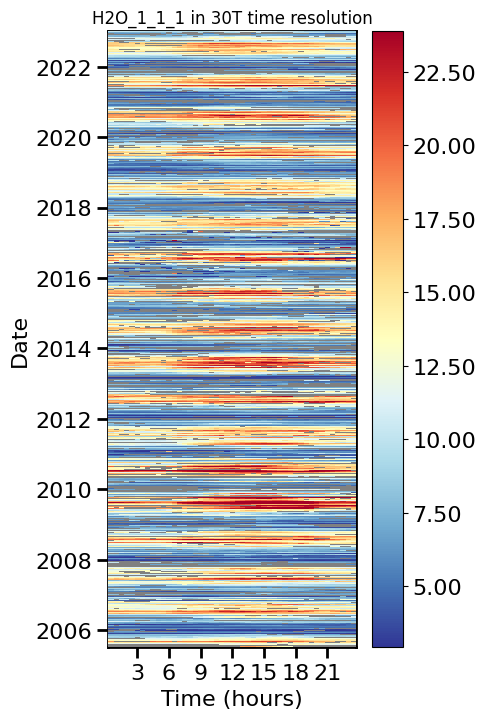

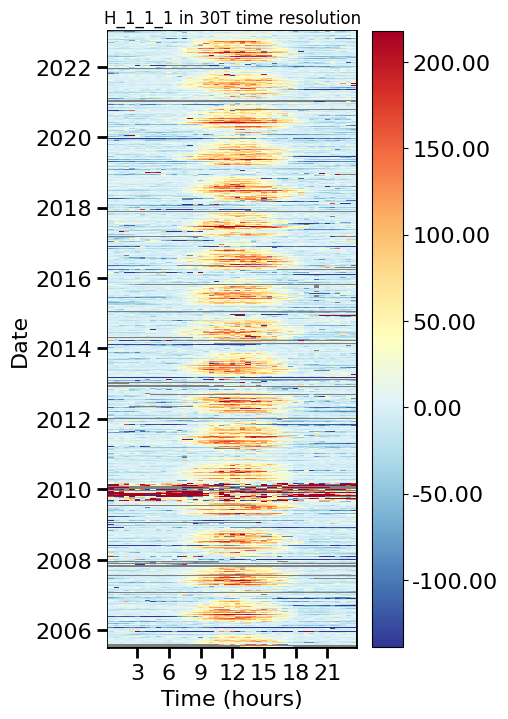

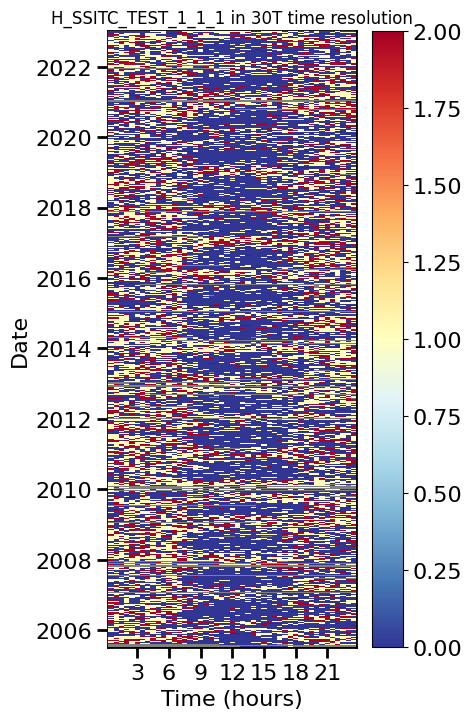

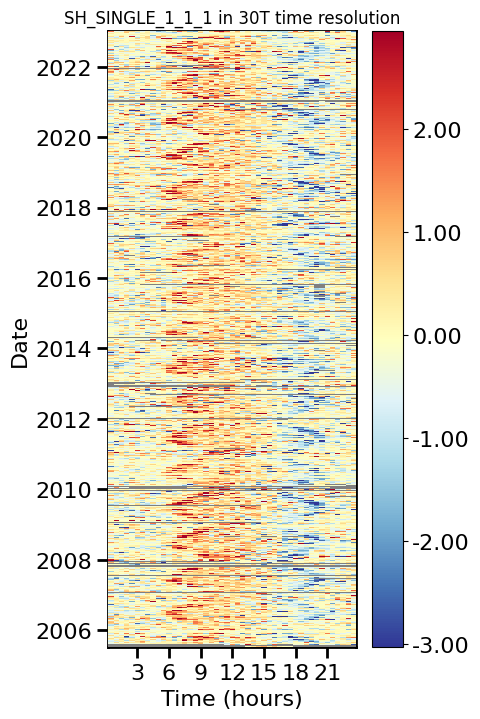

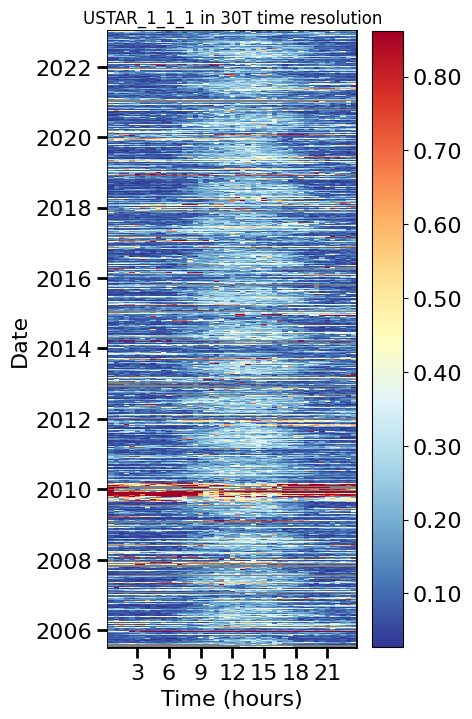

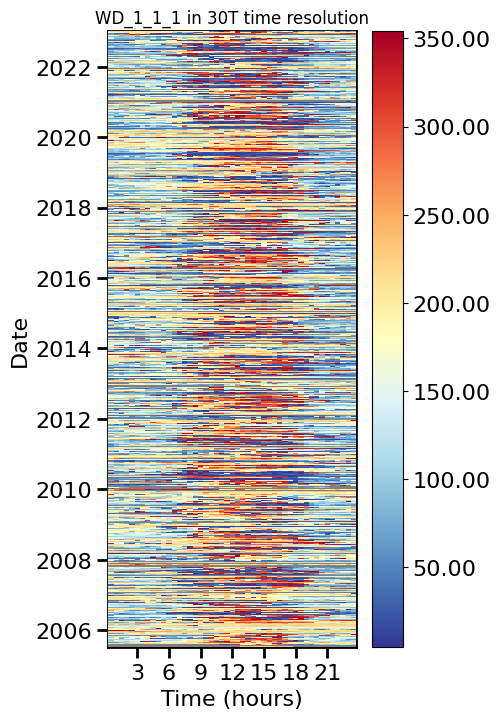

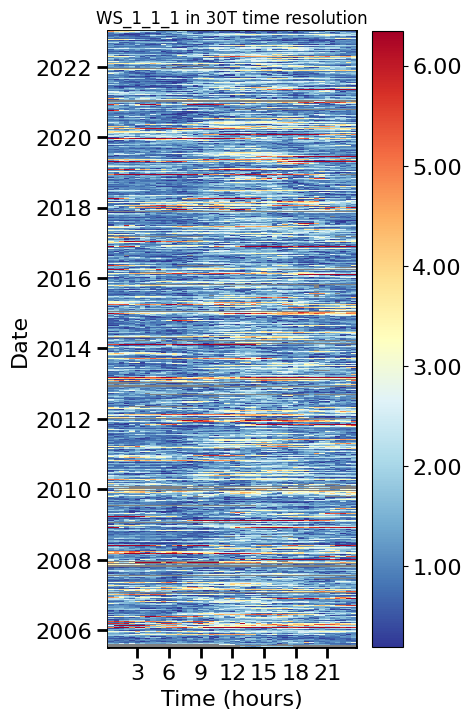

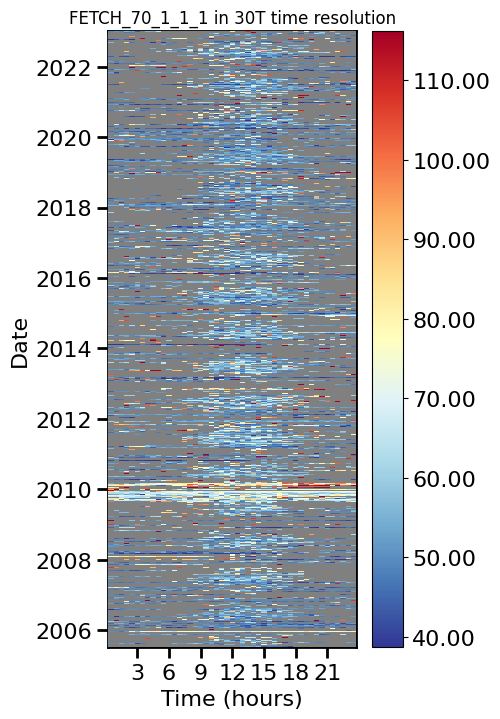

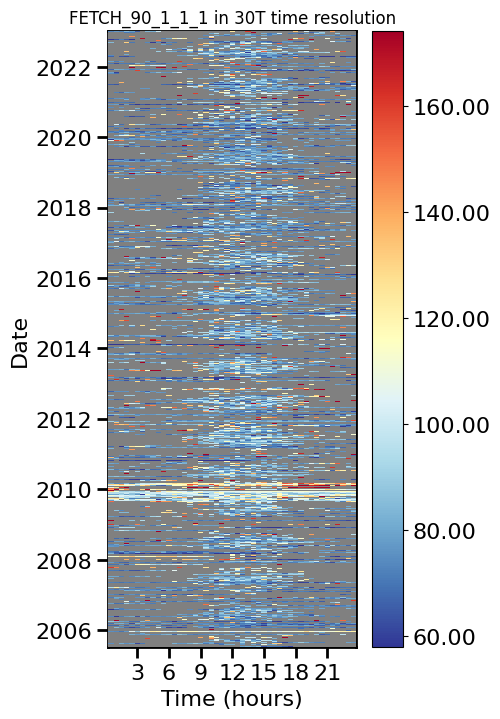

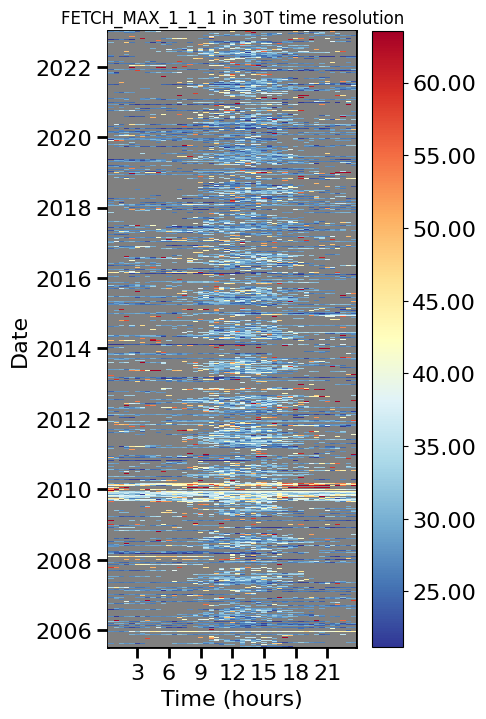

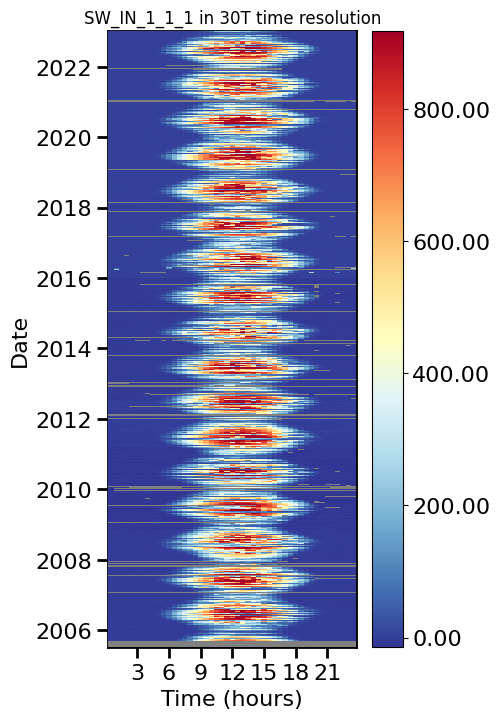

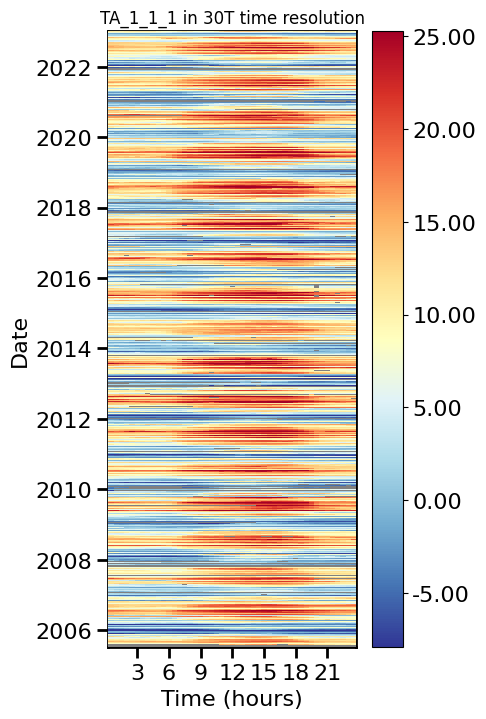

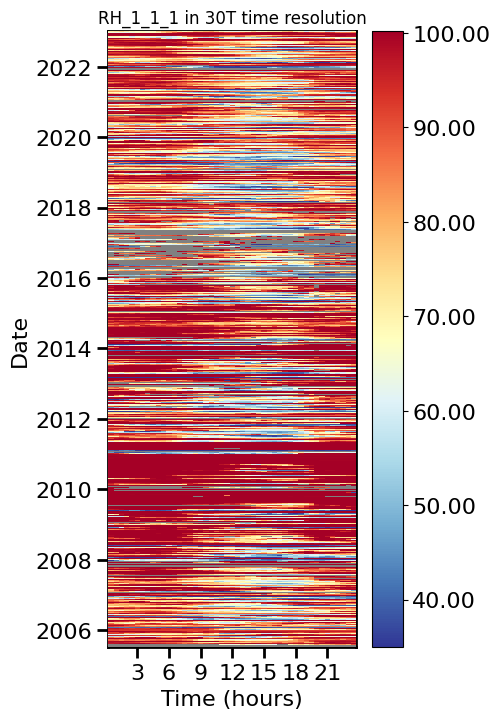

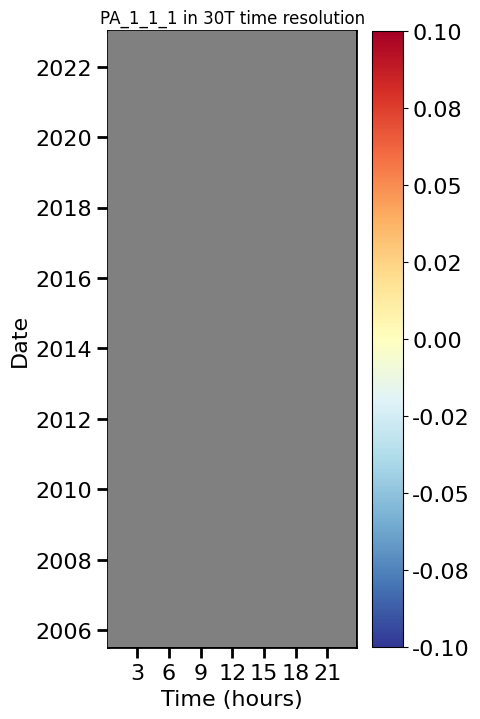

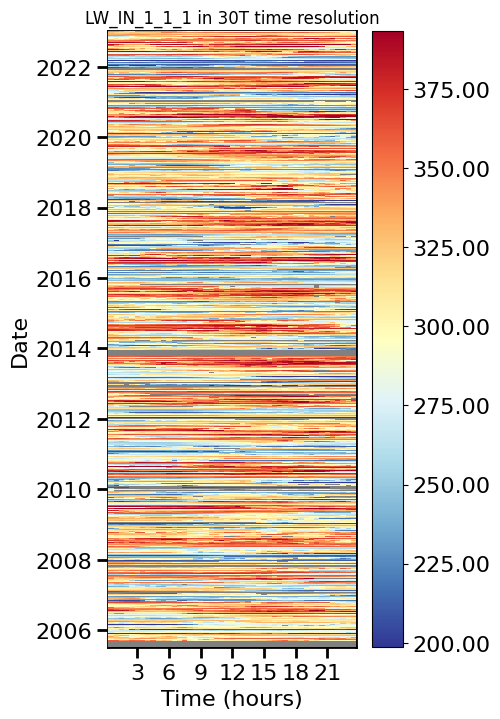

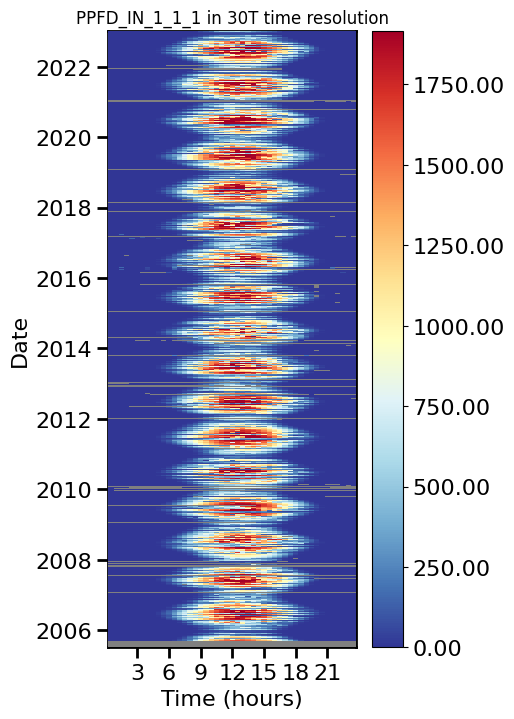

In [26]:
for col in data_fluxnet.columns:
    series = data_fluxnet[col].copy()
    series.replace(to_replace=-9999, value=np.nan, inplace=True)
    try:
        fig = plt.figure(facecolor='white', figsize=(4, 8))
        gs = gridspec.GridSpec(1, 1)  # rows, cols
        ax = fig.add_subplot(gs[0, 0])
        vmin = series.quantile(.01)
        vmax = series.quantile(.99)
        HeatmapDateTime(ax=ax, series=series, vmin=vmin, vmax=vmax).plot()
        ax_fc.set_title(col, color='black')
        fig.show()
    except TypeError:
        pass

In [ ]:
fig = plt.figure(facecolor='white', figsize=(16, 9))
gs = gridspec.GridSpec(1, 3)  # rows, cols
ax_fc = fig.add_subplot(gs[0, 0])
ax_le = fig.add_subplot(gs[0, 1])
ax_ta = fig.add_subplot(gs[0, 2])
HeatmapDateTime(ax=ax_fc, series=data_fluxnet['FC_1_1_1'], vmin=-40, vmax=40).plot()
HeatmapDateTime(ax=ax_le, series=data_fluxnet['LE_1_1_1'], vmin=-100, vmax=800).plot()
HeatmapDateTime(ax=ax_ta, series=data_fluxnet['TA_1_1_1'], vmin=-20, vmax=40).plot()
ax_fc.set_title("FC_1_1_1", color='black')
ax_le.set_title("LE_1_1_1", color='black')
ax_ta.set_title("TA_1_1_1", color='black')
ax_le.tick_params(left=True, right=False, top=False, bottom=True,
                     labelleft=False, labelright=False, labeltop=False, labelbottom=True)
ax_ta.tick_params(left=True, right=False, top=False, bottom=True,
                     labelleft=False, labelright=False, labeltop=False, labelbottom=True)

# Finish

In [9]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished {dt_string}")

Finished 2023-07-01 01:13:34
